# Введение в машинное обучение
## Описание задачи
В этом модуле предстоит работать с датасетом, содержащим сведения о 40 000 ресторанах Европы,  и обучать модель, которая будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

### Описание датасета по условиям задачи

Переменные, которые содержит датасет:
1. Restaurant_id — идентификационный номер ресторана / сети ресторанов;
2. City — город, в котором находится ресторан;
3. Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
4. Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
5. Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
6. Price Range — диапазон цен в ресторане;
7. Number of Reviews — количество отзывов о ресторане;
8. Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
9. URL_TA — URL страницы ресторана на TripAdvisor;
10. ID_TA — идентификатор ресторана в базе данных TripAdvisor.

## Загрузка необходимых библиотек и функций

In [124]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import warnings; warnings.simplefilter('ignore')

In [125]:
# Фиксируем RANDOM SEED
RANDOM_SEED = 42

# Фиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [126]:
# Функция для определения границ выбросов.

def find_IQR(column):
    perc_25 = data[column].quantile(0.25, interpolation="midpoint")
    perc_75 = data[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print('Q1: {}'.format(perc_25), 'Q3: {}'.format(perc_75), 'IQR: {}'.format(IQR),
          'Граница выбросов: [{a},{b}]'.format(a=perc_25 - 1.5*IQR, b=perc_75 + 1.5*IQR), sep='\n')

## DATA

In [127]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [128]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [129]:
# Посмотрим на случайную выборку из 5 элементов
df_train.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
18019,id_631,Prague,"['Canadian', 'Fast Food', 'Diner', 'Vegetarian...",632.0,4.5,$,56.0,"[['Only Poutine in Prague', 'Tre bien'], ['08/...",/Restaurant_Review-g274707-d8442813-Reviews-Ga...,d8442813
27217,id_2891,Vienna,"['Italian', 'Austrian', 'Pizza', 'European', '...",2893.0,3.5,$$ - $$$,9.0,"[['nothing really to rave about', 'Outsize por...",/Restaurant_Review-g190454-d11876446-Reviews-P...,d11876446
27950,id_1884,Milan,"['Seafood', 'Vegetarian Friendly', 'Vegan Opti...",1886.0,4.0,$$ - $$$,79.0,"[[], []]",/Restaurant_Review-g187849-d11045534-Reviews-C...,d11045534
31395,id_1923,London,"['British', 'Vegetarian Friendly']",1927.0,4.5,$$ - $$$,200.0,"[['Fantastic night.', 'THE way to see London a...",/Restaurant_Review-g186338-d1422087-Reviews-Lo...,d1422087
16360,id_9561,Paris,NaN,9563.0,4.0,NaN,14.0,"[['Don not order the Pad Thai!'], ['08/17/2015']]",/Restaurant_Review-g187147-d7622694-Reviews-Ku...,d7622694


In [130]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [131]:
df_test.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
731,id_731,Berlin,"['German', 'Fast Food', 'Vegetarian Friendly']",1484.0,$,56.0,"[['Why not?', 'quick service, good food'], ['0...",/Restaurant_Review-g187323-d7629581-Reviews-Ch...,d7629581
8822,id_8822,London,['British'],8190.0,$$ - $$$,2.0,"[['A fantastic Thanksgiving Dinner', 'Wonderfu...",/Restaurant_Review-g186338-d12697053-Reviews-C...,d12697053
8941,id_8941,Copenhagen,NaN,1106.0,NaN,NaN,"[['GO!'], ['02/15/2014']]",/Restaurant_Review-g189541-d4697027-Reviews-Mi...,d4697027
7098,id_7098,Lyon,"['French', 'Brazilian', 'International', 'Heal...",1264.0,$$ - $$$,22.0,"[['Amazing Brazilian restaurant', 'Amazing Foo...",/Restaurant_Review-g187265-d8784419-Reviews-Un...,d8784419
3069,id_3069,Hamburg,NaN,1275.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187331-d2006091-Reviews-Ma...,d2006091


In [132]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [133]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


Для корректной обработки признаков объединяем train и test в один датасет.

In [134]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [136]:
data.sample(7)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
10148,id_746,Lisbon,"['European', 'Vegetarian Friendly']",747.0,$$ - $$$,42.0,"[['Hidden treasure for tartar lovers', 'Absolu...",/Restaurant_Review-g189158-d10064175-Reviews-T...,d10064175,1,4.5
26436,id_698,Lyon,"['Italian', 'Pizza', 'European']",699.0,$$ - $$$,83.0,"[['Excellent pizza', 'Wonderful find on a cool...",/Restaurant_Review-g187265-d2371102-Reviews-St...,d2371102,1,4.0
8420,id_8420,London,['British'],10243.0,$$ - $$$,13.0,"[['Grandsons Birthday Brunch', 'Kevin'], ['06/...",/Restaurant_Review-g186338-d4072304-Reviews-P_...,d4072304,0,0.0
22773,id_7831,London,"['Bar', 'British', 'Pub']",7840.0,$$ - $$$,112.0,"[['A Sanctuary From the Shopping', 'Good Pub i...",/Restaurant_Review-g186338-d7619607-Reviews-Th...,d7619607,1,4.0
23782,id_8140,Madrid,"['Japanese', 'Sushi']",8147.0,$$ - $$$,67.0,[['Worst service ever (too bad for them as th....,/Restaurant_Review-g187514-d4167468-Reviews-Su...,d4167468,1,3.0
3272,id_3272,Oporto,"['European', 'Portuguese']",1116.0,$$ - $$$,20.0,"[['Stay away', 'Great Portuguese Restaurant in...",/Restaurant_Review-g189180-d7235855-Reviews-Re...,d7235855,0,0.0
4104,id_4104,Rome,"['Italian', 'Vegetarian Friendly']",2140.0,$,174.0,"[['best place for italian Aperitivo', 'good si...",/Restaurant_Review-g187791-d7256293-Reviews-Il...,d7256293,0,0.0


В получившемся объединённом датасете мы видим 10 признаков (sample не считаем, так как это искуственный признак для дальнейшего разделения датасета). Три признака заполнены числовыми значениями (Ranking, Number of Reviews и Rating), остальные - номинативными. В некоторых признаках содержится достаточно большое количество пропусков. По условиям задания мы не можем удалять строки, так что будем заполнять пропуски и, возможно, создавать отдельный признак пропусков, так как отсуствия значения может быть также важной информацией для модели.

In [137]:
# Переименуем колонки для удобства обращения к признакам
data.rename(columns={'Restaurant_id': 'rest_id', 'City': 'city',
                     'Cuisine Style': 'cuisine_style', 'Ranking': 'ranking',
                     'Rating': 'rating', 'Price Range': 'price_range',
                    'Number of Reviews': 'number_of_rev', 'Reviews': 'reviews',
                    'URL_TA': 'url_ta', 'ID_TA': 'id_ta'}, inplace=True)

data.columns

Index(['rest_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_of_rev', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating'],
      dtype='object')

## Cleaning and Prepping Data

In [138]:
# Оценим количество пропусков в итоговом датасете
data.isnull().sum()

rest_id              0
city                 0
cuisine_style    11590
ranking              0
price_range      17361
number_of_rev     3200
reviews              2
url_ta               0
id_ta                0
sample               0
rating               0
dtype: int64

Рассмотрим каждый признак отдельно
### 'rest_id'

In [139]:
# Проверим наличие зависимости между данным признаком и признаком ranking и оценим корреляцию.
data[['rest_id', 'ranking']].corr()

,ranking
ranking,1.0


Да, корреляция есть. В таком случае признак rest_id удалим позже - на случай, если он пригодится для формирования новых признаков.

### 'city'

In [140]:
data.city.describe()

count      50000
unique        31
top       London
freq        7193
Name: city, dtype: object

In [141]:
data.city.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

In [142]:
data.city.isnull().sum()

0

В данном признаке пропуски отсутствуют 

### 'number_of_rev'

In [143]:
data.number_of_rev.describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_rev, dtype: float64

In [144]:
data.number_of_rev.isnull().sum()

3200

У нас присутствует 3200 пропусков. Отсутствие данного значения может быть важной информацией для модели. Поэтому давайте вынесем все пропуски в отдельный признак. А пропуски заполним нулем.

In [145]:
data['number_of_rev_is_NAN'] = pd.isna(data.number_of_rev).astype('uint8')
data.number_of_rev.fillna(0, inplace=True)

In [146]:
# Проверим признак на наличие выбросов
find_IQR('number_of_rev')

Q1: 7.0
Q3: 105.0
IQR: 98.0
Граница выбросов: [-140.0,252.0]


In [147]:
# Посмотрим, сколько значений у нас выбиывается за верхнюю границу выбросов.
sum(data.number_of_rev > 252)

5946

Достаточно много. Посмотрим распределение на гистограмме, чтобы не отсекать сразу так много.

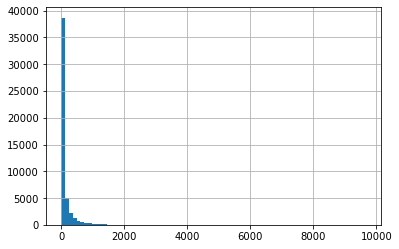

In [148]:
data.number_of_rev.hist(bins=80)

Так, мы видим что гистограмма смещена вправо, хвост длинный и уходит на убыль где-то в районе значения 1200. Посмотрим, сколько у нас значения больше 1200.

In [149]:
sum(data.number_of_rev > 1200)

571

In [150]:
# Давайте заменим эти значения на 1200.
data.number_of_rev = data.number_of_rev.apply(lambda x: 1200 if x > 1200 else x)
# И проверим результат
data.number_of_rev.describe()

count    50000.000000
mean       107.395580
std        204.081303
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       1200.000000
Name: number_of_rev, dtype: float64

### 'price_range'

In [151]:
data.price_range.value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [152]:
sum(data.price_range.isnull())

17361

In [153]:
# Вынесем пропуски в отдельный признак, присвоим значениям порядковый номер, a пропуски заменим на ноль.
price = {'$' : 1, '$$ - $$$' : 2, '$$$$' : 3}
data.price_range = data.price_range.map(price)
data['price_range_is_NAN'] = pd.isna(data.price_range).astype('uint8')
data.price_range = data.price_range.fillna(0)

In [154]:
# Проверим результат
data.price_range.value_counts()

2.0    23041
0.0    17361
1.0     7816
3.0     1782
Name: price_range, dtype: int64

### 'id_ta'

In [157]:
data.id_ta.value_counts()

d11674463    2
d697406      2
d5618007     2
d4914988     2
d11999956    2
            ..
d7705243     1
d10537028    1
d4324960     1
d12897461    1
d1420121     1
Name: id_ta, Length: 49963, dtype: int64

Интересно, у нас есть рестораны с одним и тем же идентификатором в системе, следует рассмотреть их более поподробно.

In [158]:
# Посмотрим, сколько у нас таких ресторанов
sum(data.id_ta.value_counts() > 1)

37

In [159]:
# Теперь вернёмся к колонке rest_id и посмотрим, есть ли там дважды встречающиеся значения
sum(data.rest_id.value_counts() >= 2)

9287

В ситуации с rest_id можно предположить, что это какая-то сеть ресторанов (н-р, Макдональдс). Следственно мы можем создать признак, который бы указывал, является ли ресторан частью сети или нет. В ситуации с id_ta может быть это некая компания, которая владеет несколькими разными ресторанами. Сказать сложно. Давайте отфильтруем эти значения и посмотрим на них повнимательнее.

In [160]:
data.rest_id.nunique()

13094

In [161]:
data_id_ta_notunique = data[data['id_ta'].map(data['id_ta'].value_counts()) > 1]
data_id_ta_notunique.id_ta = data_id_ta_notunique.id_ta.apply(lambda x: int(x[1:]))
data_id_ta_notunique.id_ta.value_counts()

987900      2
10316215    2
1235635     2
4748208     2
10440367    2
11698990    2
1568045     2
4914988     2
13002276    2
4600226     2
12488993    2
7337366     2
3748757     2
1028622     2
9877640     2
1315077     2
5617412     2
697406      2
7809594     2
2010743     2
7827387     2
10047799    2
2669414     2
3161682     2
2360290     2
11674463    2
2477531     2
5618007     2
11921719    2
11999956    2
7342803     2
793170      2
3396817     2
8753348     2
3685055     2
3647024     2
9802625     2
Name: id_ta, dtype: int64

In [162]:
# Посмотрим на пару таких ресторанов с одинаковым идентификатором в базе данных TripAdvisor.
data_id_ta_notunique.query('id_ta == 987900')

,rest_id,city,cuisine_style,ranking,price_range,number_of_rev,reviews,url_ta,id_ta,sample,rating,number_of_rev_is_NAN,price_range_is_NAN
18019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2363.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900,1,4.0,0,0
32998,id_2312,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2314.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900,1,4.0,0,0


Мы видим, что все значения, кроме rest_id и ranking совпадают. Теперь давайте проверим их url страницы.

In [168]:
print(data_id_ta_notunique.url_ta[18019], 
      data_id_ta_notunique.url_ta[32998], sep = '\n')

/Restaurant_Review-g187514-d987900-Reviews-Compostela_Restaurante-Madrid.html
/Restaurant_Review-g187514-d987900-Reviews-Compostela_Restaurante-Madrid.html


Нет, адреса идентичные. Значит в нашем датасете дублируется 37 ресторанов. Однако по условиям задачи удалять строки из датасета нельзя. Поэтому не трогаем эти дубликаты. Возможно, затем колонку id_ta удалим за ненадобностью, пока просто уберем символ d в начале и приведем к числовому значению и пойдем дальше.

In [169]:
data.id_ta = data.id_ta.apply(lambda x: int(x[1:]))

### 'url_ta'

In [184]:
data.loc[data.url_ta[0]:4]

,rest_id,city,cuisine_style,ranking,price_range,number_of_rev,reviews,url_ta,id_ta,sample,rating,number_of_rev_is_NAN,price_range_is_NAN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,0.0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,0.0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,0.0,0,0


In [185]:
print(data.url_ta[0], data.url_ta[1], sep = '\n')

/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html
/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html


Мы видим, что url ресторана состоит из двух закодированных величин. Первая, судя по совпадениям, означает город, вторая совпадает с id_ta. Парсинг данных мы в данной задаче мы не используем. Давайте отделим код города.

In [186]:
data.url_ta = data.url_ta.apply(lambda x: x[20:26])
data.url_ta = data.url_ta.apply(lambda x: float(x))
data.url_ta[1]

189934.0

У нас осталось еще два нетронутых признака - стиль кухни и сами отзывы. Так как это текстовые объекты, а нам для модели необходимы числовые, то данные признаки сами по себе мы обработать не можем, но можем на их основе создать новые числовые признаки.

## Feature Engineering
### 'cuisine_style'

In [189]:
type(data.cuisine_style[0])

str

In [190]:
data.cuisine_style.isnull().sum()

11590

У нас 11590 пустых значений. Давайте вынесем их в отдельный признак. Предположим, что ресторан и сам не определился со стилем кухни, поэтому ничего не указывает. И может это будет полезно для модели.

In [191]:
data['cuisine_style_is_NAN'] = pd.isna(data.cuisine_style).astype('uint8')

# Пустые значения заполним категорией Other.
data.cuisine_style = data.cuisine_style.fillna("['Other']")

# переформатируем строку в список
data.cuisine_style = data.cuisine_style.apply(lambda x: eval(x))

# Добавим признак кол-ва кухонь в ресторане.
data['number_of_cuisines'] = data.cuisine_style.apply(lambda x: len(x))

In [192]:
# Посмотрим, какие кухни у нас чаще всего встречаются, а какие наоборот являются самыми редкими.
group_city_cuisine = data.groupby(['city'])['cuisine_style'].sum().reset_index()

In [193]:
group_city_cuisine

,city,cuisine_style
0,Amsterdam,"[Dutch, European, Vegetarian Friendly, Vegan O..."
1,Athens,"[Greek, Other, Mediterranean, European, Greek,..."
2,Barcelona,"[Other, Mediterranean, Spanish, Vegetarian Fri..."
3,Berlin,"[Other, Cafe, German, Other, Italian, Pizza, O..."
4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve..."
5,Brussels,"[Italian, Mediterranean, Pizza, Moroccan, Medi..."
6,Budapest,"[Other, Italian, Pizza, Street Food, Hungarian..."
7,Copenhagen,"[European, Scandinavian, Danish, Italian, Pizz..."
8,Dublin,"[Italian, Pizza, European, Gluten Free Options..."
9,Edinburgh,"[Vegetarian Friendly, Seafood, European, Briti..."


Посчитаем кол-во уникальных кухонь, используя счетчик. Посмотрим, какие кухни входят топ-10 самых часто и самых редко встречающиеся.

In [199]:
c = collections.Counter()

for cuisine_style in group_city_cuisine.cuisine_style:
    for x in cuisine_style:
        c[x] += 1

print('Самые популярные: ', c.most_common(10))
print()
print('Самые непопулярные: ', c.most_common()[-10:])

Самые популярные:  [('Vegetarian Friendly', 14021), ('European', 12561), ('Other', 11590), ('Mediterranean', 7820), ('Italian', 7433), ('Vegan Options', 5684), ('Gluten Free Options', 5185), ('Bar', 4094), ('French', 3970), ('Asian', 3786)]

Самые непопулярные:  [('Caucasian', 4), ('Azerbaijani', 3), ('Welsh', 3), ('Yunnan', 2), ('Polynesian', 2), ('Fujian', 2), ('Latvian', 1), ('Burmese', 1), ('Salvadoran', 1), ('Xinjiang', 1)]


Добавим признак, имеет ли ресторан кухню, входящую в топ-10 по популярности и по редкости.

In [200]:
# Признак самых часто встречающихся кухонь
top_10_cuisine = []
top_10_cuisine = data.explode('cuisine_style')['cuisine_style'].value_counts()[
    data.explode('cuisine_style')['cuisine_style'].value_counts() >= 3786].index.tolist()

In [201]:
def most_common_cuisines(column):
    x = 0
    for i in top_10_cuisine:
        if i in column:
            x += 1
    return x

data['most_common_cuisine'] = data.cuisine_style.apply(most_common_cuisines)

In [202]:
# Признак самых редко встречающихся кухонь
top_unique_cuisine = []
top_unique_cuisine = data.explode('cuisine_style')['cuisine_style'].value_counts()[
    data.explode('cuisine_style')['cuisine_style'].value_counts() <= 4].index.tolist()

In [203]:
def top_unique_cuisines(column):
    x = 0
    for i in top_unique_cuisine:
        if i in column:
            x += 1
    return x

data['top_unique_cuisine'] = data.cuisine_style.apply(top_unique_cuisines)

### 'reviews'

In [204]:
data.reviews.isnull().sum()

2

In [205]:
data.reviews.value_counts()

[[], []]                                                                                                           8112
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]                               2
[['Excellent cuisine, friendly and helpful se...', 'Not tasty'], ['12/25/2016', '06/05/2016']]                        2
[['Very average food. Over average prices.', 'great food with great service!'], ['11/17/2017', '08/17/2017']]         2
[['Nice restaurant in Madrid', 'Highly reccomended'], ['11/10/2017', '05/21/2017']]                                   2
                                                                                                                   ... 
[['太好吃😋 Extremely Good Sichuan food 🥘', 'Great chinese restaurant'], ['12/06/2017', '06/02/2017']]                    1
[['Great experience', 'Amazing service, best Japanese in Milano'], ['12/16/2017', '12/10/2017']]                      1
[['Very very good experience!', 'Fine ch

Мы видим, что данный признак состоит из текстового отзыва и даты. У нас есть два явных пропуска и 8112 пропусков не явных, которые не имеют внутри ничего кроме скобок. Отсутствие отзыва может быть важным для модели, поэтому давайте вынесем все отзывы в отдельный признак.

In [206]:
data['review_is_NAN'] = (data.reviews == '[[], []]').astype('uint8')
data['review_is_NAN'] = pd.isna(data.reviews).astype('uint8')

Отделим дату от отзыва и посмотрим, какую информацию мы можем получить из даты.

In [207]:
data['date_of_review'] = data['reviews'].apply(
    lambda x: [0] if pd.isna(x) else x[2:-2].split('], [')[1][1:-1].split("', '"))

In [208]:
# Добавим признак кол-ва дней между отзывами.
data['days_between_reviews'] = data.date_of_review.apply(lambda x: None if x == [] else pd.to_datetime(x).max() - pd.to_datetime(x).min())

data.days_between_reviews.describe()

count                       41888
mean     123 days 05:05:55.462184
std      212 days 14:08:22.315988
min               0 days 00:00:00
25%               8 days 00:00:00
50%              49 days 00:00:00
75%             148 days 00:00:00
max            3296 days 00:00:00
Name: days_between_reviews, dtype: object

У нас есть максимальное значение в 3296 дней. Давайте переведем значения в числа и посмотрим выбросы.

In [209]:
data['days_between_reviews'] = data['days_between_reviews'].apply(lambda x: x.days)

In [211]:
# посмотрим выбросы
find_IQR('days_between_reviews')

Q1: 8.0
Q3: 148.0
IQR: 140.0
Граница выбросов: [-202.0,358.0]


In [212]:
len(data.query('days_between_reviews > 358'))

3492

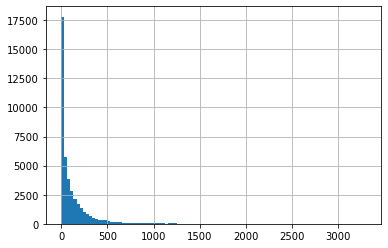

In [213]:
data.days_between_reviews.hist(bins=100)

По выбросам мы видим, что хвост тянется непрерывно до 1200. Давайте посмотрим, сколько у нас таких значений и сгладим выбросы, присвоив им пограничное значение 1200.

In [214]:
len(data.query('days_between_reviews > 1200'))

285

In [215]:
data.days_between_reviews = data.days_between_reviews.apply(lambda x: 1200 if x > 1200 else x)

In [216]:
len(data.query('days_between_reviews > 1200'))

0

In [217]:
data.days_between_reviews.isnull().sum()

8112

Пропусков очень много, давайте заполним их медианой.

In [218]:
data.days_between_reviews.describe()

count    41888.000000
mean       120.315651
std        190.546256
min          0.000000
25%          8.000000
50%         49.000000
75%        148.000000
max       1200.000000
Name: days_between_reviews, dtype: float64

In [221]:
data.days_between_reviews = data.days_between_reviews.fillna(data.days_between_reviews.median())
data.days_between_reviews.isnull().sum()

0

Добавим ещё один признак - количество дней с последнего отзыва до настоящего момента.

In [222]:
data['days_till_now'] = data.date_of_review.apply(
    lambda x: None if x == [] else datetime.now() - pd.to_datetime(x).max())

data['days_till_now'] = data['days_till_now'].apply(lambda x: x.days)
data.days_till_now.isnull().sum()

8112

In [225]:
data.days_till_now.describe()

count    41888.000000
mean      1391.871276
std        382.403027
min       1101.000000
25%       1180.000000
50%       1254.500000
75%       1438.000000
max      18689.000000
Name: days_till_now, dtype: float64

In [226]:
# Теперь заменим пропуски на среднее.
data.days_till_now = data.days_till_now.fillna(data.days_till_now.mean())

In [227]:
data.days_till_now.isnull().sum()

0

In [229]:
data.sample(7)

,rest_id,city,cuisine_style,ranking,price_range,number_of_rev,reviews,url_ta,id_ta,sample,...,number_of_rev_is_NAN,price_range_is_NAN,cuisine_style_is_NAN,number_of_cuisines,most_common_cuisine,top_unique_cuisine,review_is_NAN,date_of_review,days_between_reviews,days_till_now
11618,id_2666,Vienna,"[Austrian, Polish, European, Russian, Eastern ...",2668.0,1.0,0.0,"[[], []]",190454.0,11538645,1,...,1,0,0,6,1,0,0,[],49.0,1391.871276
5850,id_5850,Paris,"[French, Bar, European, Gastropub]",4132.0,2.0,124.0,"[['Excellent food second visit', 'Great food, ...",187147.0,4167666,0,...,0,0,0,4,3,0,0,"[06/16/2017, 05/06/2017]",41.0,1356.000000
17243,id_753,Barcelona,"[Japanese, European, Spanish, Mediterranean, V...",754.0,2.0,867.0,"[['Great location good food', 'Great setting, ...",187497.0,6657102,1,...,0,0,0,7,5,0,0,"[12/21/2017, 12/18/2017]",3.0,1168.000000
42492,id_1487,Copenhagen,[Other],1490.0,0.0,7.0,"[['Good value for a quick meal'], ['06/26/2016']]",189541.0,7995294,1,...,0,1,1,1,1,0,0,[06/26/2016],0.0,1711.000000
38889,id_8701,London,[Other],8710.0,0.0,12.0,"[['Sad', 'Fantastic fresh food, but a but pric...",186338.0,7346902,1,...,0,1,1,1,1,0,0,"[09/16/2016, 02/18/2016]",211.0,1629.000000
2818,id_2818,Milan,"[Italian, Vegetarian Friendly]",1636.0,1.0,37.0,"[['Fantastic place to chill or work', 'Cute pl...",187849.0,8001669,0,...,0,0,0,2,2,0,0,"[07/06/2017, 04/18/2017]",79.0,1336.000000
17709,id_670,Hamburg,[Other],671.0,0.0,25.0,"[['Cozy cafe', 'Great look and feel excellent ...",187331.0,6966863,1,...,0,1,1,1,1,0,0,"[07/23/2016, 06/11/2016]",42.0,1684.000000


## Рассмотрим распределение признаков

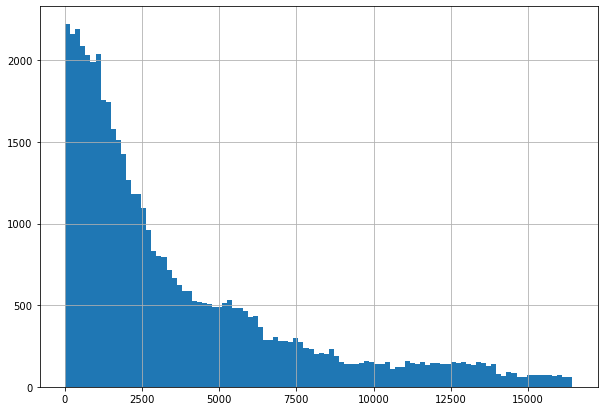

In [230]:
plt.rcParams['figure.figsize'] = (10,7)
data['ranking'].hist(bins=100)

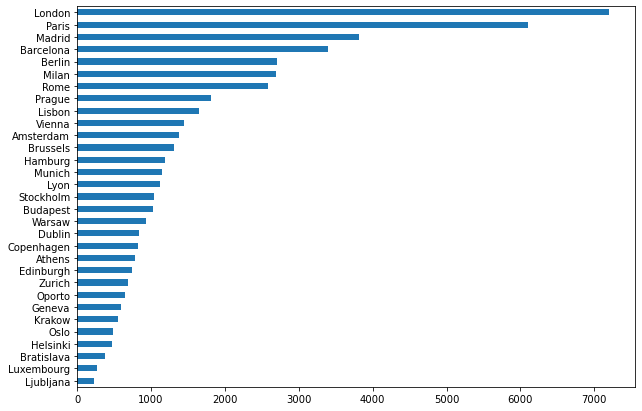

In [231]:
data['city'].value_counts(ascending=True).plot(kind='barh')

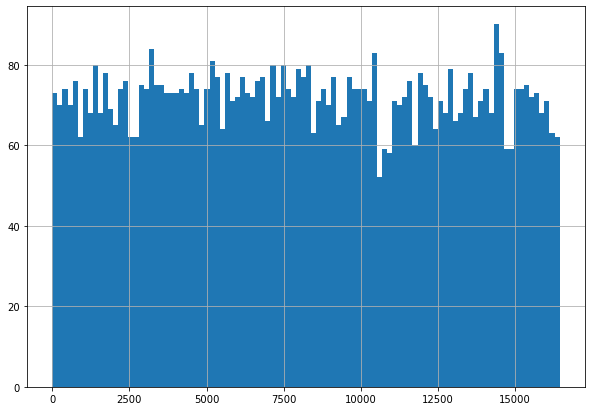

In [232]:
data['ranking'][data['city'] =='London'].hist(bins=100)

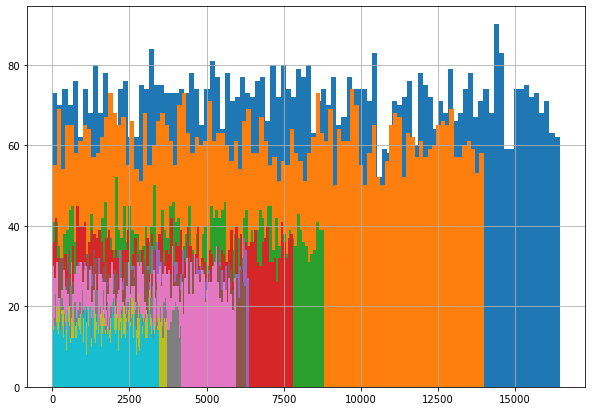

In [233]:
# посмотрим на топ-10 городов
for x in (data['city'].value_counts())[0:10].index:
    data['ranking'][data['city'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение. Но из-за того, что в больших городах ресторанов больше, наблюдается смещение.

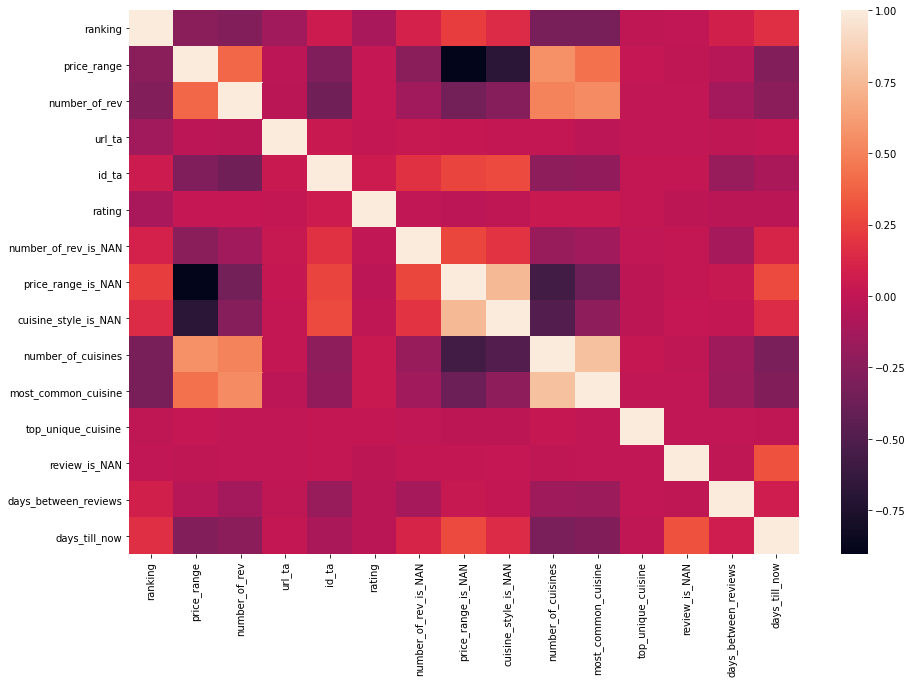

In [234]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Добавим несколько признаков, которые могут улучшить работу нашей модели.

#### 1. Численность населения (по данным Евростат за 2019г)

In [237]:
population = {
    'London' : 8982458,
    'Paris' : 2140526,
    'Madrid' : 6642519,
    'Barcelona' : 5575897,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2879728,
    'Prague' : 1309277,
    'Lisbon' : 509627,
    'Vienna' : 1867582,
    'Amsterdam' : 880562,
    'Brussels' : 1209542,
    'Hamburg' : 1841179,
    'Munich' : 1472226,
    'Lyon' : 506615,
    'Stockholm' : 2352549,
    'Budapest' : 1752286,
    'Warsaw' : 1790658,
    'Dublin' : 1388453,
    'Copenhagen' : 1096187,
    'Athens' : 754123,
    'Edinburgh' : 524964, 
    'Zurich' : 1539678,
    'Oporto' : 287591,
    'Geneva' : 499480, 
    'Krakow' : 779115, 
    'Oslo' : 681067, 
    'Helsinki' : 656229,
    'Bratislava' : 425923,
    'Luxembourg' : 613894,
    'Ljubljana' : 284355
}

data['population'] = data.city.map(population)

#### 2. Индекс покупательской способности (по данным рейтинга Numbeo 2018г)

In [250]:
purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

data['purchasing_power'] = data.city.map(purchasing_power_index)

#### 3. Является ли город столицей (1 - да, 0 - нет)

In [251]:
capital = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague',
          'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
          'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens',
          'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava',
          'Luxembourg', 'Ljubljana']
data['is_capital'] = data.city.apply(lambda x: 1 if x in capital else 0)

#### 4. Количество ресторанов в городе

In [252]:
number_of_rest_city = data.groupby('city')['ranking'].count().to_dict()
data['rest_city_count'] = data.city.map(number_of_rest_city)

#### 5. Относительный рейтинг ресторана по городу

In [253]:
data['city_ranking'] = data.ranking / data.rest_city_count

На этом анализ и добавление признаков, связанных с городами, закончен. переходим к следующей части анализа и визуализации данных.

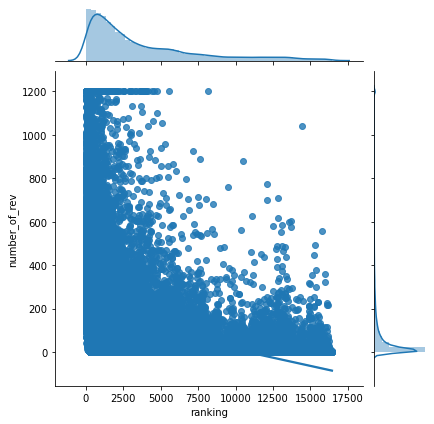

In [254]:
sns.jointplot(x = 'ranking', y = 'number_of_rev', data = data, kind = 'reg')

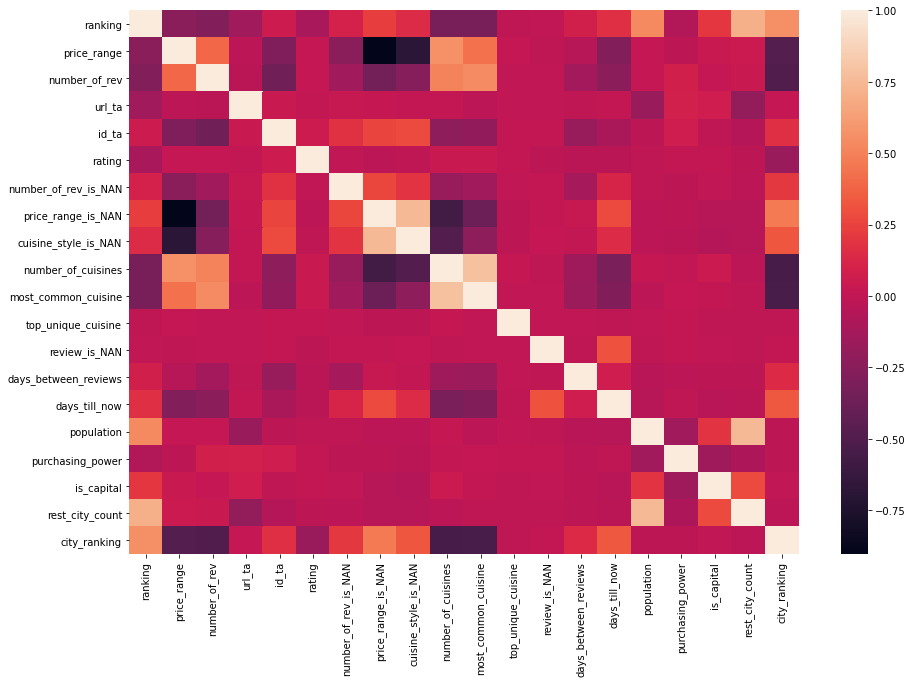

In [255]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Добавим ещё несколько признаков

#### 6. Рейтинг ресторана на основании количества отзывов

In [258]:
data['ranking_rev_count'] = data.ranking * data.number_of_rev

#### 7. Соотношение количества отзывов и населения города

In [260]:
data['reviews_per_city_pop'] = data.number_of_rev / data.population

#### 8. Признак среднее кол-во отзывов в городе

In [261]:
mean_rev_per_city = data.groupby('city')['number_of_rev'].mean()
mean_rev_per_city = mean_rev_per_city.apply(lambda x: round(x, 2))
data['mean_rev_per_city'] = data.city.map(mean_rev_per_city)

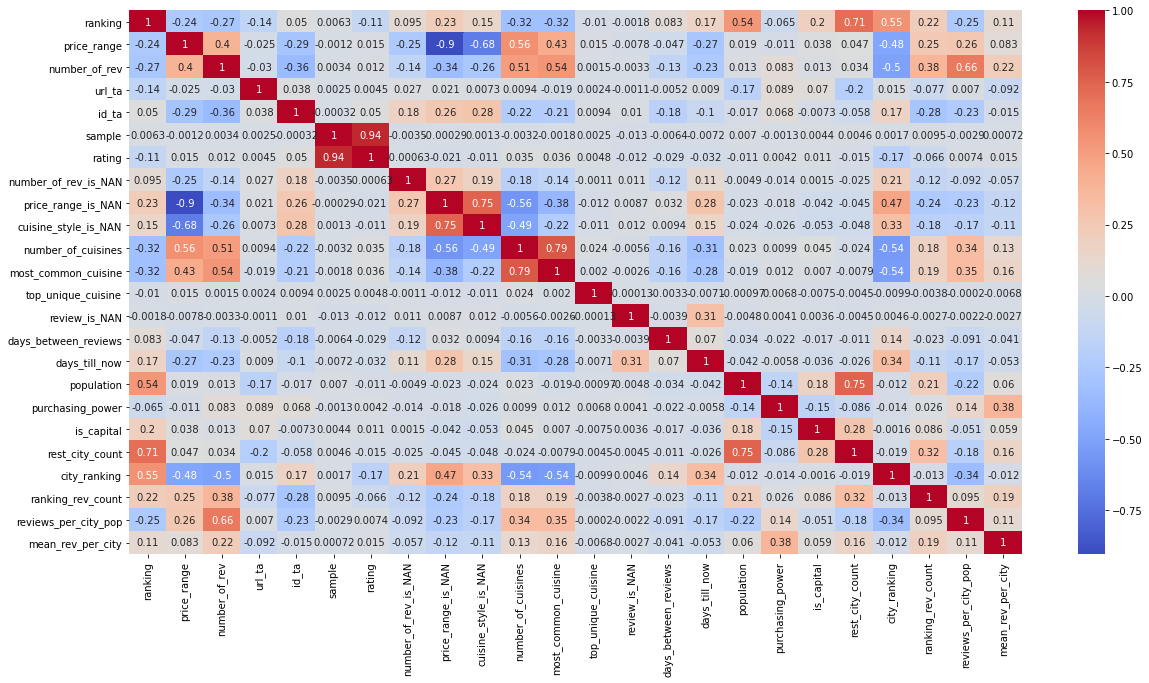

In [262]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'coolwarm')

#### 9. Туристическая привлекательность (по данным рейтинга топ-100 городов посещения в 2018 году, источник - Euromonitor international)

In [263]:
'''
Так как не все города входят в топ-100, разделим города на группы:
    1 место 1-25
    2 место 26-50
    3 место 51-75
    4 место 76-100
    5 место выше 100
'''

tourist_attract = {
    'London' : 1,
    'Paris' : 1,
    'Madrid' : 2,
    'Barcelona' : 2,
    'Berlin' : 2,
    'Milan' : 5,
    'Rome' : 1,
    'Prague' : 1,
    'Lisbon' : 3,
    'Vienna' : 2,
    'Amsterdam' : 1,
    'Brussels' : 3,
    'Hamburg' : 5,
    'Munich' : 3,
    'Lyon' : 5,
    'Stockholm' : 4,
    'Budapest' : 3,
    'Warsaw' : 3,
    'Dublin' : 5,
    'Copenhagen' : 3,
    'Athens' : 2,
    'Edinburgh' : 5, 
    'Zurich' : 5,
    'Oporto' : 4,
    'Geneva' : 5, 
    'Krakow' : 3, 
    'Oslo' : 5, 
    'Helsinki' : 5,
    'Bratislava' : 5,
    'Luxembourg' : 5,
    'Ljubljana' : 5
}

data['tourist_attract'] = data.city.map(tourist_attract)

Как уже было замечено, связь между городом и рейтингом ресторана оказывает довольно сильное влияние на модель, следует создать вспомогательный признак максимального рейтинга по городу.
#### 10. Максимальный рейтинг

In [264]:
ranking_max_per_city = data.groupby('city')['ranking'].max()
data['rating_max_per_city'] = data.city.map(ranking_max_per_city)

### Отбор признаков 

В ходе работы над проектом были добавлены следующие признаки: длина отзыва, входит ле ресторан в сеть ресторанов, среднее количествово туристов в городе, принадлежность к той или иной стране. Однако данные признаки ухудшили работу модели, поэтому я в итоговой модели я их не использовала.
Кроме этого экспериментально было выяснено, что признаки rest_id, number_of_rev_is_NAN, review_is_NAN, is_capital увеличивают MAE, поэтому в отборе признаков для модели я их также не учитывала.

In [265]:
data = pd.get_dummies(data, columns=['city'], dummy_na=True)

### Data Preprocessing

In [266]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rest_id               50000 non-null  object 
 1   cuisine_style         50000 non-null  object 
 2   ranking               50000 non-null  float64
 3   price_range           50000 non-null  float64
 4   number_of_rev         50000 non-null  float64
 5   reviews               49998 non-null  object 
 6   url_ta                50000 non-null  float64
 7   id_ta                 50000 non-null  int64  
 8   sample                50000 non-null  int64  
 9   rating                50000 non-null  float64
 10  number_of_rev_is_NAN  50000 non-null  uint8  
 11  price_range_is_NAN    50000 non-null  uint8  
 12  cuisine_style_is_NAN  50000 non-null  uint8  
 13  number_of_cuisines    50000 non-null  int64  
 14  most_common_cuisine   50000 non-null  int64  
 15  top_unique_cuisine 

In [267]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 100)  # показывать больше колонок

data.sample(5)

,rest_id,cuisine_style,ranking,price_range,number_of_rev,reviews,url_ta,id_ta,sample,rating,number_of_rev_is_NAN,price_range_is_NAN,cuisine_style_is_NAN,number_of_cuisines,most_common_cuisine,top_unique_cuisine,review_is_NAN,date_of_review,days_between_reviews,days_till_now,population,purchasing_power,is_capital,rest_city_count,city_ranking,ranking_rev_count,reviews_per_city_pop,mean_rev_per_city,tourist_attract,rating_max_per_city,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
29742,id_2107,[Other],2112.0,0.0,9.0,"[['A little peice of Italia in Amsterdam', 'Fa...",188590.0,11856590,1,4.5,0,1,1,1,1,0,0,"[07/16/2017, 07/08/2017]",8.0,1326.0,880562,19,1,1372,1.539359,19008.0,0.000010,130.31,1,3254.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3579,id_3579,"[Czech, Eastern European, European, Central Eu...",1053.0,2.0,70.0,"[['Fun place', 'Typical Czech restaurant'], ['...",274707.0,1929713,0,0.0,0,0,0,4,1,0,0,"[01/04/2018, 11/07/2017]",58.0,1154.0,1309277,31,1,1816,0.579846,73710.0,0.000053,95.74,1,4188.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
20838,id_3455,"[Indian, Vegetarian Friendly, Vegan Options, H...",3456.0,1.0,74.0,"[['Great service great food', 'Briyani in Pari...",187147.0,3378206,1,4.0,0,0,0,4,2,0,0,"[06/24/2017, 11/28/2016]",208.0,1348.0,2140526,22,1,6108,0.565815,255744.0,0.000035,107.36,1,13986.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9147,id_9147,[Other],4419.0,0.0,8.0,"[['Great place in Gracia', 'A great bar !'], [...",187497.0,12194623,0,0.0,0,1,1,1,1,0,0,"[12/05/2017, 11/12/2017]",23.0,1184.0,5575897,30,0,3395,1.301620,35352.0,0.000001,116.13,2,7796.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3102,id_3102,"[Mediterranean, European, Spanish, Vegetarian ...",107.0,3.0,878.0,"[['spectacular', 'Absolutely astonishing!'], [...",187497.0,809578,0,0.0,0,0,0,6,5,0,0,"[01/07/2018, 01/01/2018]",6.0,1151.0,5575897,30,0,3395,0.031517,93946.0,0.000157,116.13,2,7796.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [268]:
df_preproc = data.drop(
    ['rest_id', 'cuisine_style', 'reviews', 'date_of_review',
    'number_of_rev_is_NAN', 'review_is_NAN', 'is_capital'], axis=1)

In [269]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ranking               50000 non-null  float64
 1   price_range           50000 non-null  float64
 2   number_of_rev         50000 non-null  float64
 3   url_ta                50000 non-null  float64
 4   id_ta                 50000 non-null  int64  
 5   sample                50000 non-null  int64  
 6   rating                50000 non-null  float64
 7   price_range_is_NAN    50000 non-null  uint8  
 8   cuisine_style_is_NAN  50000 non-null  uint8  
 9   number_of_cuisines    50000 non-null  int64  
 10  most_common_cuisine   50000 non-null  int64  
 11  top_unique_cuisine    50000 non-null  int64  
 12  days_between_reviews  50000 non-null  float64
 13  days_till_now         50000 non-null  float64
 14  population            50000 non-null  int64  
 15  purchasing_power   

In [270]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values 
X = train_data.drop(['rating'], axis=1)

Перед отправкой наших данных на обучение, разделим их на еще один тест и трейн для валидации, чтобы проверить, как хорошо наша модель работает.

In [271]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 54), (40000, 54), (40000, 53), (32000, 53), (8000, 53))

## Model

In [272]:
# Создание модели
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке 
# и записываем предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [273]:
# Так как признак рейтинга имеет шаг 0.5, округляем предсказание.
y_pred = np.round(y_pred * 2) / 2

In [274]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.162125


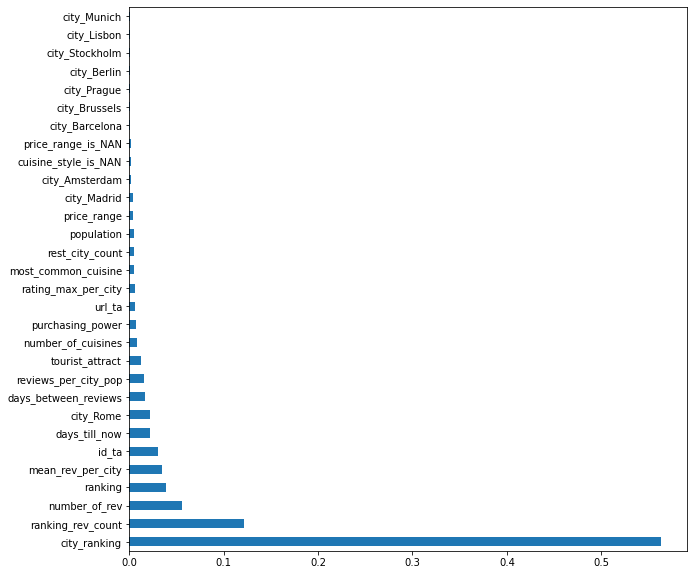

In [275]:
# Посмотрим на самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

## Submission

In [276]:
test_data.sample(10)

,ranking,price_range,number_of_rev,url_ta,id_ta,rating,price_range_is_NAN,cuisine_style_is_NAN,number_of_cuisines,most_common_cuisine,top_unique_cuisine,days_between_reviews,days_till_now,population,purchasing_power,rest_city_count,city_ranking,ranking_rev_count,reviews_per_city_pop,mean_rev_per_city,tourist_attract,rating_max_per_city,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
5852,819.0,2.0,1200.0,187147.0,714904,0.0,0,0,5,4,0,1.0,1154.000000,2140526,22,6108,0.134086,982800.0,0.000561,107.36,1,13986.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6640,1295.0,2.0,18.0,189852.0,8479516,0.0,0,0,5,1,0,86.0,1290.000000,2352549,13,1033,1.253630,23310.0,0.000008,68.65,4,2464.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5584,534.0,2.0,16.0,190479.0,1746540,0.0,0,0,1,0,0,370.0,1176.000000,681067,17,488,1.094262,8544.0,0.000023,94.84,5,1137.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9408,2970.0,2.0,616.0,186338.0,1016032,0.0,0,0,5,3,0,88.0,1186.000000,8982458,24,7193,0.412901,1829520.0,0.000069,117.09,1,16444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6721,801.0,2.0,46.0,186525.0,4026569,0.0,0,0,3,1,0,14.0,1201.000000,524964,16,745,1.075168,36846.0,0.000088,203.46,5,1766.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9742,1733.0,2.0,82.0,187323.0,10028106,0.0,0,0,4,4,0,5.0,1171.000000,3769495,8,2705,0.640665,142106.0,0.000022,55.66,2,6372.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2133,12566.0,0.0,0.0,186338.0,5814521,0.0,1,1,1,1,0,49.0,1391.871276,8982458,24,7193,1.746976,0.0,0.000000,117.09,1,16444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4478,3006.0,0.0,28.0,190454.0,798196,0.0,1,0,4,0,0,711.0,1558.000000,1867582,21,1443,2.083160,84168.0,0.000015,67.73,2,3444.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2918,1745.0,2.0,44.0,187849.0,12320420,0.0,0,0,2,0,0,190.0,1191.000000,1399860,40,2694,0.647736,76780.0,0.000031,150.83,5,6275.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6958,3195.0,2.0,10.0,187323.0,10481785,0.0,0,0,2,1,0,118.0,1392.000000,3769495,8,2705,1.181146,31950.0,0.000003,55.66,2,6372.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [277]:
test_data = test_data.drop(['rating'], axis=1)

In [278]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [279]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [280]:
predict_submission = np.round(predict_submission * 2)/2

predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [281]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
